In [5]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import nltk

In [108]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hosein/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/hosein/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [11]:
def preprocess(text):
    tokens = word_tokenize(text)
    filtered_tokens = [stemmer.stem(token) for token in tokens if token not in stop_words]
    return ' '.join(filtered_tokens)

In [109]:
df = pd.read_csv('tiktok_app_reviews.csv')
df.head()
df.info()

/var/folders/v_/t80_dx5n7gx_89b496x67k7m0000gp/T/ipykernel_6529/3409572425.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('tiktok_app_reviews.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3646476 entries, 0 to 3646475
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   review_id    object
 1   review_text  object
 2   upvotes      int64 
 3   app_version  object
 4   posted_date  object
dtypes: int64(1), object(4)
memory usage: 139.1+ MB


In [111]:
df = df.iloc[np.random.randint(0,len(df), size=10000)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1628063 to 2928426
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_id    10000 non-null  object
 1   review_text  10000 non-null  object
 2   upvotes      10000 non-null  int64 
 3   app_version  7334 non-null   object
 4   posted_date  10000 non-null  object
dtypes: int64(1), object(4)
memory usage: 468.8+ KB


In [112]:
df.drop(['app_version', 'posted_date'], axis=1, inplace=True)
condition = df['review_text'].apply(lambda x: isinstance(x, str))
df = df.where(condition).dropna()
df.head(5)

,review_id,review_text,upvotes
1628063,gp:AOqpTOE8RfB7usXjFrwdNeF8SaLt00aJaE7nOsyBNZ-...,Swag 😋🤣👍🏻,0
1223088,gp:AOqpTOGrmiLWUjla6qTv2FNn1DxNh8d-vYKLy45LanF...,I have attached my resume for tiktok,0
580765,gp:AOqpTOFu09boyyP7m-ssOyLYhoEUf5g9ZEmQk0GSfRY...,This app is very good,0
2818348,gp:AOqpTOFES-6OUGWtslXP8gbza-4umNK7KZLpxkTH6UB...,supper,0
1682507,gp:AOqpTOHsQ8_vcNRNYjtlMaCzkPs9CNvp_VWgiSW3YXl...,love it,0


In [ ]:
df["processed_text"] = df["review_text"].apply(preprocess)
df.head()

In [113]:
from transformers import DistilBertTokenizer, DistilBertModel
from torch.utils.data import Dataset, DataLoader
import torch
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

In [127]:
class TikTokDataset(Dataset):
    def __init__(self, sentences, tokenizer, max_length=30):
        self.sentences = sentences
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        tokens = self.tokenizer(sentence, return_tensors='pt', truncation=True, padding='max_length', max_length=self.max_length)
        return tokens,sentence

In [157]:
dataset = TikTokDataset(df['review_text'].tolist(), tokenizer)
batch_size = 128
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True,drop_last=True)

In [129]:
dataset[1]

({'input_ids': tensor([[  101,  1045,  2031,  4987,  2026, 13746,  2005, 14841, 25509,  6559,
            102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0]])},
 'I have attached my resume for tiktok')

In [162]:
embeddings = []
for batch in dataloader:
    input_ids = batch[0]['input_ids']
    attention_mask = batch[0]['attention_mask']
    

    with torch.no_grad():
        outputs = model(input_ids.squeeze(1), attention_mask=attention_mask.squeeze(1))
    embeddings.append((batch[1],outputs.last_hidden_state.mean(dim=1).numpy()))


In [159]:
len(embeddings[0][1][0])

768

In [163]:
temp =  [i for i,j in embeddings]
sentences = []
for i in temp:
    for j in i:
        sentences.append(j)
print(len(sentences))
temp = [j for i,j in embeddings]
print(len(temp[0][0]))
embedded_sentences = np.array(temp).reshape(-1,768)

9984
768


In [231]:
import hdbscan
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
tsne = MDS(n_components=2, random_state=42)
reduced_data = tsne.fit_transform(embedded_sentences)

cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(reduced_data)


/Users/hosein/anaconda3/envs/tiktok/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [239]:

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', -1)
pd.set_option('display.max_colwidth', None)

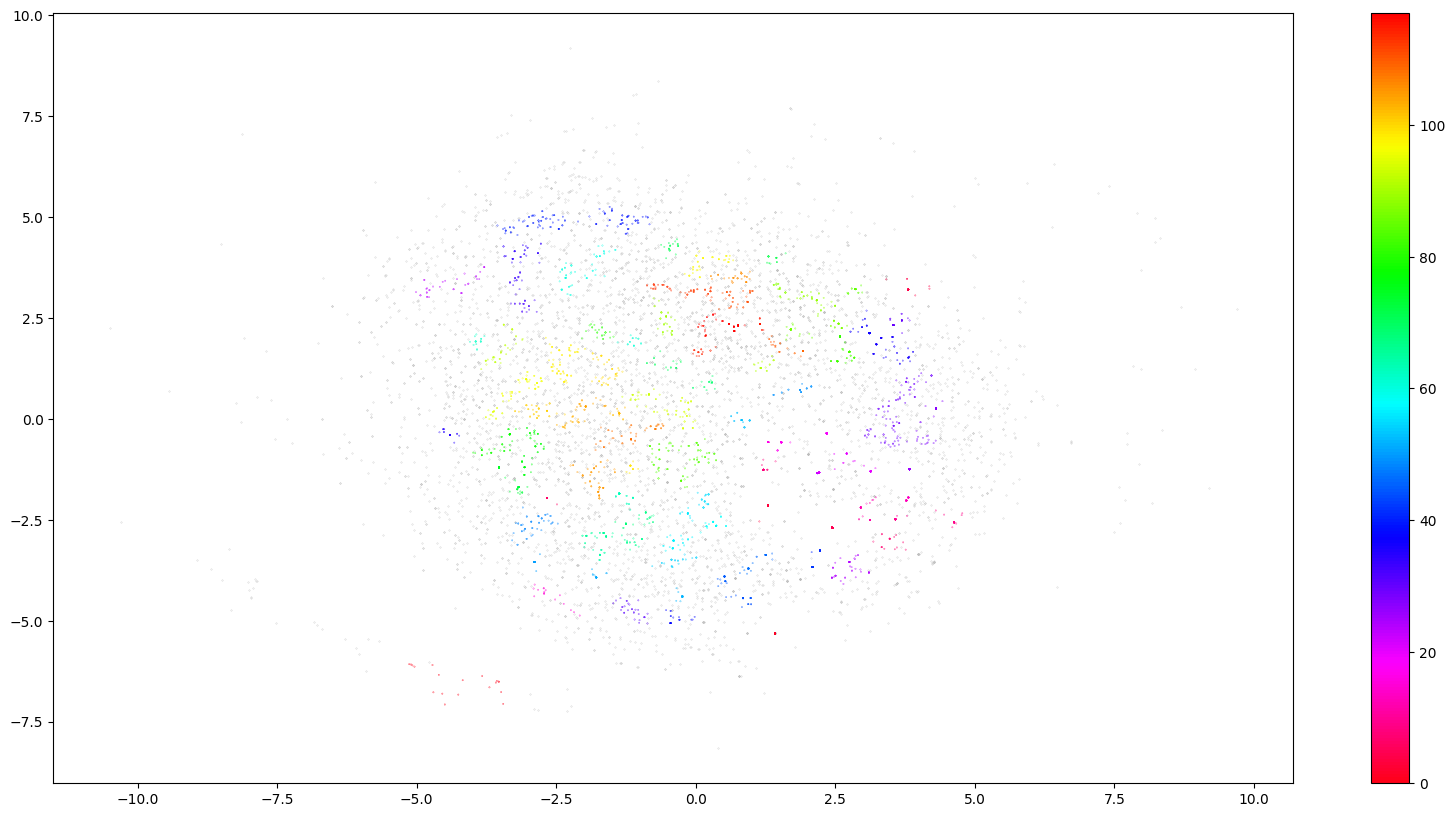

In [232]:
result = pd.DataFrame(reduced_data, columns=['x', 'y'])
result['labels'] = cluster.labels_
result['sentence'] = sentences

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [233]:
result.loc[result["sentence"].str.contains("bug")].head(50)

,x,y,labels,sentence
244,-1.664323,4.926892,-1,It does have a few bugs and I hope they fix it...
548,-1.934838,5.577022,-1,During transition is shows many bugs like song...
3547,-1.568968,6.364114,-1,I love that they fixed most of the bugs and ma...
4613,-2.725518,-0.743782,77,Thank you for fixing the bugs.😃😃
6041,-2.725518,-0.743782,77,Thank you for fixing the bugs.😃😃
6975,-0.886197,0.590828,93,Thank you for fixing the bugs.😃😃


In [244]:
result.loc[result.labels == 40].head(50)

,x,y,labels,sentence
102,-2.344361,4.912581,40,I love this app. I get on it everyday haven't made an actual video of my on yet but love watching other ppl video
201,-2.918644,5.034348,40,"I was totally against this app at first, but now I #LOVE it! It truly brings people together no matter how old, young, tall, short..you get the point. Two thumbs up!"
411,-2.455030,4.704062,40,I LOVE IT It is an amazing app and all. I love that you get to see your freinds on vids
430,-2.745892,4.995329,40,It seems as if this app can read my mind or an algorithm of some type I love you is innovative very very on time for this pandemic and everything in the world is going through right now Tick Tock rules apps of all apps
956,-3.331011,4.744548,40,This app is cool but you have to be tik tok famous and its probably even more fun to make silly videos and it works really well
1021,-2.887001,5.036514,40,I think that it is the best app in the whole world it is really superb I loved it very much
1462,-2.989525,4.999478,40,I love this app but peapole are starting to be inapropiate i rated 5 stars but i think i might only sorry but only .........3 ... stars im sorry
1844,-3.411950,4.594645,40,"Dear, Tik Tok Team i think my tik tok account @sierra_freefire is freezed, please review my tik tok account @sierra_freefire do it unfreeze. Thank you"
1849,-2.455144,4.703998,40,I LOVE IT It is an amazing app and all. I love that you get to see your freinds on vids
1890,-2.818611,4.912214,40,"Very nice...I m in luv with this app becoz it helped me to find my 1st luv❤️❤️❤️ #the Tiktok star RIYAZ ALY....I luv u tiktok ,tysm ❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️"


In [236]:
result.value_counts('labels').sort_values

<bound method Series.sort_values of labels
-1      5226
 3       323
 5       318
 1       119
 81      111
 6       100
 29       99
 84       96
 37       86
 115      85
 98       68
 40       61
 26       58
 25       58
 96       57
 20       57
 105      57
 117      57
 36       55
 39       54
 48       49
 24       48
 94       48
 16       48
 30       46
 17       46
 97       45
 89       45
 75       45
 19       44
 109      42
 90       42
 9        42
 57       42
 101      40
 111      40
 100      40
 73       40
 63       40
 58       40
 8        38
 10       38
 83       38
 86       38
 92       38
 65       38
 4        37
 108      37
 23       36
 106      36
 2        36
 34       35
 112      34
 22       34
 78       34
 77       33
 85       33
 93       31
 60       31
 31       30
 21       30
 44       29
 104      28
 79       27
 18       27
 59       27
 27       26
 47       26
 46       26
 42       26
 87       25
 53       25
 80       25
 54     